In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, ZeroPadding2D, Input, MaxPool2D, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [2]:
TRAINING_DIR = 'C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\train\\'
VALIDATION_DIR = 'C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\valid\\'
TESTING_DIR = 'C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\test\\'
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224)
SEED = 777
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [3]:
tf.random.set_seed(SEED)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 84635 images belonging to 525 classes.
Batch index: 4992


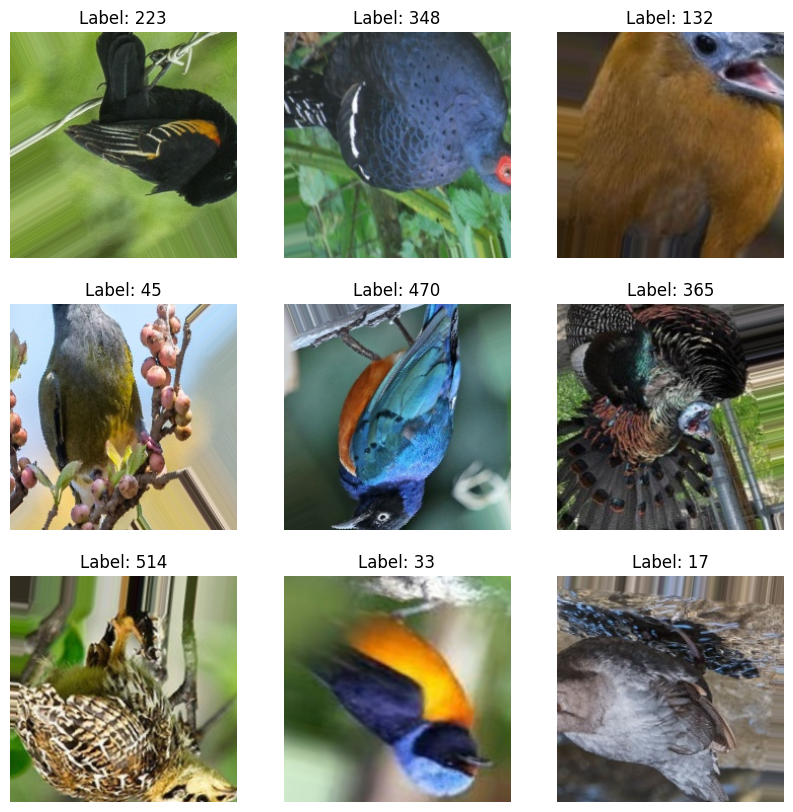

In [4]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40
)
training_set = training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)
validation_gen = ImageDataGenerator(rescale=1./255)
validation_set = validation_gen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)

testing_gen = ImageDataGenerator(rescale=1./255)
testing_set = testing_gen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)
# Generating images
generated_images = next(training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=9,
    target_size=INPUT_SHAPE,
    class_mode=None,
    shuffle=False
))


def decode_one_hot(labels):
    return [label.argmax() for label in labels]


# Choose a random batch index from the dataset
batch_index = random.randint(0, len(training_set) - 1)
print("Batch index:", batch_index)

# Retrieve the batch of images and labels
random_images, random_labels = training_set[batch_index]

# Decode the one-hot encoded labels
random_labels = decode_one_hot(random_labels)

# Limit the number of images to display to 9
num_images_to_display = min(len(random_images), 9)

# Display the random images with their corresponding class labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")
plt.show()

In [5]:
def resnet_block(input_layer, num_filters, kernel_size=3, strides=1, activation='relu'):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size,
                      strides=strides, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(num_filters, kernel_size=kernel_size,
                      strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    if strides != 1:
        input_layer = layers.Conv2D(
            num_filters, kernel_size=1, strides=strides, padding='same')(input_layer)
    x = layers.add([x, input_layer])
    x = layers.Activation(activation)(x)
    return x


def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Parameters
input_shape = (224, 224, 3)  
num_classes = 525  

# Build the model
model = build_resnet(input_shape, num_classes)
# model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Train the model
history = model.fit(
    training_set,
    # steps_per_epoch = len(training_set),
    epochs=10,
    validation_data=validation_set,
    # validation_steps=int(0.25*len(validation_set))
)

Epoch 1/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1726s 326ms/step - accuracy: 0.0092 - loss: 6.0213 - val_accuracy: 0.1211 - val_loss: 4.3429
Epoch 2/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1701s 321ms/step - accuracy: 0.1221 - loss: 4.3517 - val_accuracy: 0.2804 - val_loss: 3.4156
Epoch 3/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1736s 328ms/step - accuracy: 0.2767 - loss: 3.3246 - val_accuracy: 0.4507 - val_loss: 2.3646
Epoch 4/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1779s 336ms/step - accuracy: 0.3875 - loss: 2.7272 - val_accuracy: 0.5429 - val_loss: 1.9949
Epoch 5/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1711s 323ms/step - accuracy: 0.4720 - loss: 2.3079 - val_accuracy: 0.5741 - val_loss: 1.8043
Epoch 6/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1702s 322ms/step - accuracy: 0.5332 - loss: 2.0113 - val_accuracy: 0.6465 - val_loss: 1.4513
Epoch 7/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1733s 327ms/step - accuracy: 0.5773 - loss: 1.7751 - val_accuracy: 0.4507 - val_loss: 2.7696
Epoch 8/10
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 1741s 329ms/s

In [9]:
# Save the model
model.save('resnet_model.h5')
model.save_weights('resnet.weights.h5')

In [11]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(training_set)
print(f'Train Accuracy: {train_acc*100:.2f}%')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(testing_set)
print(f'Test Accuracy: {test_acc*100:.2f}%')

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_set)
print(f'Val Accuracy: {val_accuracy*100:.2f}%')

5290/5290 ━━━━━━━━━━━━━━━━━━━━ 654s 124ms/step - accuracy: 0.6858 - loss: 1.2753
Train Accuracy: 68.45%
  2/165 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.7188 - loss: 1.1204 

c:\Users\divij\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.7593 - loss: 1.0371
Test Accuracy: 75.20%
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7404 - loss: 1.0886
Val Accuracy: 73.41%


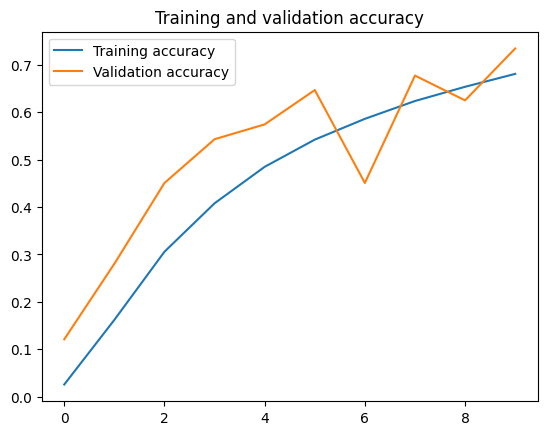

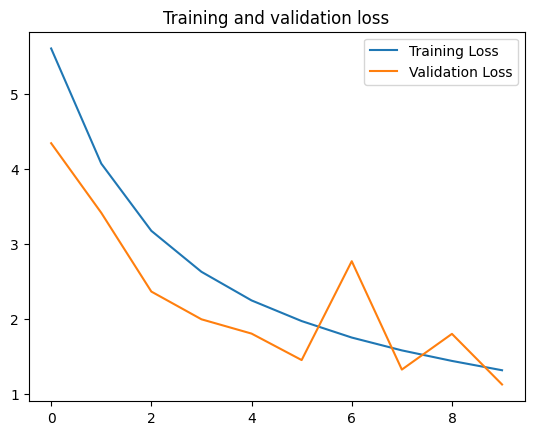

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()